# NIRCam Depth vs. Exposure Time

#### JDox links: 
* [NIRCam Imaging Sensitivity](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-imaging-sensitivity)
    * Figure 1. Depth vs. exposure time
 
*** 
<div class="alert alert-warning">

**Warning:** This notebook assumes you have installed Pandeia according to the JDox instructions here: [Installing Pandeia](https://jwst-docs.stsci.edu/display/JPP/Installing+Pandeia)

</div>

***

## Imports

In [1]:
import os
import json
import numpy as np  
import astropy.io.fits as pyfits

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')  # for others to use

In [3]:
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc

#### Background benchmark

https://jwst-docs.stsci.edu/jwst-exposure-time-calculator-overview/jwst-etc-pandeia-engine-tutorial/pandeia-backgrounds
    
https://jwst-docs.stsci.edu/jwst-general-support/jwst-background-model
    
Benchmark "minzodi" has a zodiacal emission that is 20% higher than the celestial minimum:
* June 19
* ecliptic Long, Lat = 266.3°, −50.0°
* RA, Dec [J2000] = 17h26m44s, −73°19'56"

#### Test calculation

In [4]:
calculation = build_default_calc("jwst", "nircam", "sw_imaging")

In [5]:
calculation['background'] = 'minzodi'
calculation['background_level'] = 'benchmark'

In [6]:
results = perform_calculation(calculation)

/Users/dcoe/miniconda3/envs/pandeia_dev_11_07_2022/lib/python3.8/site-packages/pandeia.engine-1.8.dev0-py3.8.egg/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


In [7]:
results

{'sub_reports': [],
 'input': {'configuration': {'detector': {'nexp': 1,
    'ngroup': 10,
    'nint': 1,
    'readout_pattern': 'deep2',
    'subarray': 'full'},
   'dynamic_scene': True,
   'instrument': {'aperture': 'sw',
    'disperser': None,
    'filter': 'f070w',
    'instrument': 'nircam',
    'mode': 'sw_imaging'},
   'max_filter_leak': 0.05,
   'max_scene_size': 10.0,
   'scene_size': 2.0},
  'scene': [{'shape': {'shape_parameters': [], 'geometry': 'point'},
    'position': {'y_offset': 0.0,
     'position_parameters': ['x_offset', 'y_offset', 'orientation'],
     'orientation': 0.0,
     'x_offset': 0.0},
    'spectrum': {'extinction': {'value': 0.0,
      'unit': 'mag',
      'bandpass': 'j',
      'law': 'mw_rv_31'},
     'sed': {'sed_type': 'flat', 'unit': 'fnu', 'z': 0.0},
     'normalization': {'type': 'at_lambda',
      'norm_wave': 2.0,
      'norm_flux': 0.001,
      'norm_fluxunit': 'mjy',
      'norm_waveunit': 'microns'},
     'name': 'generic source',
     'spect

In [8]:
# Test
#results = perform_calculation(imgr_data)

######
# Edit parameters and try one calculation

calculation = build_default_calc("jwst", "nircam", "sw_imaging")

calculation['scene'][0]['spectrum']['normalization']['norm_flux'] = mag = 29
calculation['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
calculation['configuration']['detector']['nexp'] = nexp = 4
calculation['configuration']['detector']['nint'] = nint = 1
calculation['configuration']['detector']['ngroup'] = ngroup = 5
calculation['configuration']['detector']['readout_pattern'] = readmode = 'bright1'  # previously 'readmode'
calculation['configuration']['instrument']['filter'] = filt = 'f200w'
calculation['background'] = 'minzodi'
calculation['background_level'] = 'benchmark'

ch = 'sw'
calculation['configuration']['instrument']['aperture'] = ch
calculation['configuration']['instrument']['mode'] = ch+'_imaging'
calculation['strategy']['aperture_size'] = 0.08  # radius (default 0.1")
calculation['strategy']['sky_annulus'] = 0.6, 0.99  # (default 0.22" - 0.4")

results = perform_calculation(calculation)
exptime = results['scalar']['total_exposure_time']  # previously 'exposure_time'

line = readmode.ljust(10)
snr = results['scalar']['sn']
line += '%2d  %2d  %2d  %7.2f  %12.8f' % (ngroup, nint, nexp, exptime, snr)
print(line)
print("Initial test complete...")

bright1    5   1   4   386.52    0.77327413
Initial test complete...


In [9]:
results

{'sub_reports': [],
 'input': {'configuration': {'detector': {'nexp': 4,
    'ngroup': 5,
    'nint': 1,
    'readout_pattern': 'bright1',
    'subarray': 'full'},
   'dynamic_scene': True,
   'instrument': {'aperture': 'sw',
    'disperser': None,
    'filter': 'f200w',
    'instrument': 'nircam',
    'mode': 'sw_imaging'},
   'max_filter_leak': 0.05,
   'max_scene_size': 10.0,
   'scene_size': 2.0},
  'scene': [{'shape': {'shape_parameters': [], 'geometry': 'point'},
    'position': {'y_offset': 0.0,
     'position_parameters': ['x_offset', 'y_offset', 'orientation'],
     'orientation': 0.0,
     'x_offset': 0.0},
    'spectrum': {'extinction': {'value': 0.0,
      'unit': 'mag',
      'bandpass': 'j',
      'law': 'mw_rv_31'},
     'sed': {'sed_type': 'flat', 'unit': 'fnu', 'z': 0.0},
     'normalization': {'type': 'at_lambda',
      'norm_wave': 2.0,
      'norm_flux': 29,
      'norm_fluxunit': 'abmag',
      'norm_waveunit': 'microns'},
     'name': 'generic source',
     'spect

#### Create ladder of exposure times using recommended readout patterns and numbers of groups

In [10]:
#readmodes = 'rapid bright1 bright2 shallow2 shallow4 medium2 medium8 deep2 deep8'.split()
#readmodes = 'bright1 shallow4 medium8 deep8'.split()  # bright2 ngroups > 4 not allowed
readmodes = 'bright1 shallow4 medium8_nexp4 medium8_nexp6 medium8_nexp8 medium8_nexp10 medium8_nexp12'.split()  # bright2 ngroups > 4 not allowed

readpats = []
for readmode in readmodes:
    if 'bright' in readmode:
        ngroups = np.arange(5, 10.1)  # NGROUPS = 1 doesn't work
    elif 'shallow' in readmode:
        ngroups = np.arange(5, 10.1)  # NGROUPS = 1 doesn't work
    elif 'medium' in readmode:
        ngroups = np.arange(6, 10.1)  # pick up where the last group left off
    #elif 'deep' in readmode:
    #    ngroups = np.arange(6,21)  # pick up where the last group left off
    for ngroup in ngroups:
        readpat = readmode + ' %d' % ngroup
        readpats.append(readpat)
        print(readpat)

bright1 5
bright1 6
bright1 7
bright1 8
bright1 9
bright1 10
shallow4 5
shallow4 6
shallow4 7
shallow4 8
shallow4 9
shallow4 10
medium8_nexp4 6
medium8_nexp4 7
medium8_nexp4 8
medium8_nexp4 9
medium8_nexp4 10
medium8_nexp6 6
medium8_nexp6 7
medium8_nexp6 8
medium8_nexp6 9
medium8_nexp6 10
medium8_nexp8 6
medium8_nexp8 7
medium8_nexp8 8
medium8_nexp8 9
medium8_nexp8 10
medium8_nexp10 6
medium8_nexp10 7
medium8_nexp10 8
medium8_nexp10 9
medium8_nexp10 10
medium8_nexp12 6
medium8_nexp12 7
medium8_nexp12 8
medium8_nexp12 9
medium8_nexp12 10


# Perform the calculations

In [11]:
snr0 = 10  # desired SNR
nint = 1
#mags = np.arange(25.9,31,0.2) + 0.1
mags = np.arange(25.9,31,0.05) + 0.1
mags = mags - 2.5 * np.log10(snr0 / 5.)

results_dir = 'results_snr%d' % snr0
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

filts = 'f090w f115w f150w f200w f277w f356w f410m f444w'.split()
for filt in filts:
    nexp = 4
    print(filt)
    lam = int(filt[1:4])
    if lam < 240:
        ch = 'sw'
        calculation['strategy']['aperture_size'] = 0.08  # radius (default 0.1")
        calculation['strategy']['sky_annulus'] = 0.6, 0.99  # (default 0.22" - 0.4")
    else:
        ch = 'lw'
        calculation['strategy']['aperture_size'] = 0.16  # radius (default 0.1")
        calculation['strategy']['sky_annulus'] = 1.2, 1.98  # (default 0.22" - 0.4")

    calculation['configuration']['instrument']['aperture'] = ch
    calculation['configuration']['instrument']['mode'] = ch+'_imaging'

    calculation['configuration']['instrument']['filter'] = filt

    ireadpat = 0

    for mag in mags:
        print(filt, 'mag', mag)
        calculation['scene'][0]['spectrum']['normalization']['norm_flux'] = mag
        calculation['configuration']['detector']['nexp'] = nexp
    
        outfile = 'etc_snr_%dexp_%s_mag%5.2f.txt' % (nexp, filt, mag)
        outfile = os.path.join(results_dir, outfile)
        if os.path.exists(outfile):
            print(outfile, 'EXISTS.  SKIPPING...')
            continue
        
        fout = open(outfile, 'w')
        snr = 0
        ireadpat1 = ireadpat
        while snr < snr0:
            readpat = readpats[ireadpat]
            #print filt, readpat
            readmode, ngroup = readpat.split()
            if '_' in readmode:
                readmode, nexp = readmode.split('_')
                nexp = int(nexp[4:])  # e.g., nexp10
            ngroup = int(ngroup)
            calculation['configuration']['detector']['nexp'] = nexp
            calculation['configuration']['detector']['ngroup'] = ngroup
            calculation['configuration']['detector']['readout_pattern'] = readmode  # previously 'readmode'
            results = perform_calculation(calculation)
            exptime = results['scalar']['total_exposure_time']  # previously 'exposure_time'
            snr = results['scalar']['sn']
            line = readmode.ljust(10)
            line += '%2d  %2d  %2d  %7.2f  %12.8f' % (ngroup, nint, nexp, exptime, snr)
            print(line)
            if snr > snr0:
                if ireadpat:
                    if ireadpat == ireadpat1:
                        # If SNR > snr0 on the first attempt, then go back to previous shallower pattern
                        print('Going back one...')
                        readpat = readpats[ireadpat-1]
                        readmode, ngroup = readpat.split()
                        if '_' in readmode:
                            readmode, nexp = readmode.split('_')
                            nexp = int(nexp[4:])  # e.g., nexp10
                        ngroup = int(ngroup)
                        calculation['configuration']['detector']['nexp'] = nexp
                        calculation['configuration']['detector']['ngroup'] = ngroup
                        calculation['configuration']['detector']['readout_pattern'] = readmode  # previously 'readmode'
                        results1 = perform_calculation(calculation)
                        exptime1 = results1['scalar']['total_exposure_time']  # previously 'exposure_time'
                        snr1 = results1['scalar']['sn']
                        line1 = readmode.ljust(10)
                        line1 += '%2d  %2d  %2d  %7.2f  %12.8f' % (ngroup, nint, nexp, exptime1, snr1)
                        print(line1)
                        fout.write(line1+'\n')
                    
            fout.write(line+'\n')
            #print readmode, ngroup, exptime, snr
            if snr < snr0:
                ireadpat += 1
                
            if ireadpat == len(readpats):
                break  # final read pattern didn't yield snr > snr0

        fout.close()
        print(outfile)
        print
        
        if ireadpat == len(readpats):
            break  # mag loop; can't go fainter; final read pattern didn't yield snr > snr0

f090w
f090w mag 25.247425010840047
bright1    5   1   4   386.52   14.84120976
results_snr10/etc_snr_4exp_f090w_mag25.25.txt
f090w mag 25.297425010840048
bright1    5   1   4   386.52   14.20974181
results_snr10/etc_snr_4exp_f090w_mag25.30.txt
f090w mag 25.34742501084005
bright1    5   1   4   386.52   13.60371571
results_snr10/etc_snr_4exp_f090w_mag25.35.txt
f090w mag 25.39742501084005
bright1    5   1   4   386.52   13.02222165
results_snr10/etc_snr_4exp_f090w_mag25.40.txt
f090w mag 25.44742501084005
bright1    5   1   4   386.52   12.46437230
results_snr10/etc_snr_4exp_f090w_mag25.45.txt
f090w mag 25.49742501084005
bright1    5   1   4   386.52   11.92930281
results_snr10/etc_snr_4exp_f090w_mag25.50.txt
f090w mag 25.54742501084005
bright1    5   1   4   386.52   11.41617522
results_snr10/etc_snr_4exp_f090w_mag25.55.txt
f090w mag 25.597425010840052
bright1    5   1   4   386.52   10.92417261
results_snr10/etc_snr_4exp_f090w_mag25.60.txt
f090w mag 25.647425010840053
bright1    5   1  

shallow4  10   1   4  2104.41    9.92125097
medium8    6   1   4  2490.93   11.04593199
results_snr10/etc_snr_4exp_f090w_mag27.75.txt
f090w mag 27.797425010840083
medium8    6   1   4  2490.93   10.57439411
Going back one...
shallow4  10   1   4  2104.41    9.49615957
results_snr10/etc_snr_4exp_f090w_mag27.80.txt
f090w mag 27.847425010840084
medium8    6   1   4  2490.93   10.12198472
Going back one...
shallow4  10   1   4  2104.41    9.08843880
results_snr10/etc_snr_4exp_f090w_mag27.85.txt
f090w mag 27.897425010840085
medium8    6   1   4  2490.93    9.68800801
medium8    7   1   4  2920.40   10.68090424
results_snr10/etc_snr_4exp_f090w_mag27.90.txt
f090w mag 27.947425010840085
medium8    7   1   4  2920.40   10.22317846
Going back one...
medium8    6   1   4  2490.93    9.27178705
results_snr10/etc_snr_4exp_f090w_mag27.95.txt
f090w mag 27.997425010840086
medium8    7   1   4  2920.40    9.78416288
medium8    8   1   4  3349.87   10.58605441
results_snr10/etc_snr_4exp_f090w_mag28.00.t

bright1    9   1   4   730.10   10.69066811
Going back one...
bright1    8   1   4   644.21    9.28358198
results_snr10/etc_snr_4exp_f115w_mag26.55.txt
f115w mag 26.597425010840066
bright1    9   1   4   730.10   10.23163035
Going back one...
bright1    8   1   4   644.21    8.88208997
results_snr10/etc_snr_4exp_f115w_mag26.60.txt
f115w mag 26.647425010840067
bright1    9   1   4   730.10    9.79142890
bright1   10   1   4   815.99   11.05920647
results_snr10/etc_snr_4exp_f115w_mag26.65.txt
f115w mag 26.697425010840067
bright1   10   1   4   815.99   10.58558823
Going back one...
bright1    9   1   4   730.10    9.36936153
results_snr10/etc_snr_4exp_f115w_mag26.70.txt
f115w mag 26.747425010840068
bright1   10   1   4   815.99   10.13130467
Going back one...
bright1    9   1   4   730.10    8.96474695
results_snr10/etc_snr_4exp_f115w_mag26.75.txt
f115w mag 26.79742501084007
bright1   10   1   4   815.99    9.69564194
shallow4   5   1   4  1030.73   13.58873115
results_snr10/etc_snr_4exp

medium8    7   1  12  8761.20    8.88610545
medium8    8   1  12  10049.62    9.62103313
medium8    9   1  12  11338.03   10.27721551
results_snr10/etc_snr_10exp_f115w_mag28.80.txt
f115w mag 28.847425010840098
medium8    9   1  12  11338.03    9.82617540
medium8   10   1  12  12626.44   10.39287704
results_snr10/etc_snr_12exp_f115w_mag28.85.txt
f115w mag 28.8974250108401
medium8   10   1  12  12626.44    9.93649780
results_snr10/etc_snr_12exp_f115w_mag28.90.txt
f150w
f150w mag 25.247425010840047
bright1    5   1   4   386.52   20.29706671
results_snr10/etc_snr_4exp_f150w_mag25.25.txt
f150w mag 25.297425010840048
bright1    5   1   4   386.52   19.44996587
results_snr10/etc_snr_4exp_f150w_mag25.30.txt
f150w mag 25.34742501084005
bright1    5   1   4   386.52   18.63572678
results_snr10/etc_snr_4exp_f150w_mag25.35.txt
f150w mag 25.39742501084005
bright1    5   1   4   386.52   17.85326899
results_snr10/etc_snr_4exp_f150w_mag25.40.txt
f150w mag 25.44742501084005
bright1    5   1   4   386

shallow4   6   1   4  1245.47    9.20695510
results_snr10/etc_snr_4exp_f150w_mag27.70.txt
f150w mag 27.747425010840082
shallow4   7   1   4  1460.20   10.03107813
Going back one...
shallow4   6   1   4  1245.47    8.81164528
results_snr10/etc_snr_4exp_f150w_mag27.75.txt
f150w mag 27.797425010840083
shallow4   7   1   4  1460.20    9.60178894
shallow4   8   1   4  1674.94   10.65142988
results_snr10/etc_snr_4exp_f150w_mag27.80.txt
f150w mag 27.847425010840084
shallow4   8   1   4  1674.94   10.19647204
Going back one...
shallow4   7   1   4  1460.20    9.19000390
results_snr10/etc_snr_4exp_f150w_mag27.85.txt
f150w mag 27.897425010840085
shallow4   8   1   4  1674.94    9.75999323
shallow4   9   1   4  1889.67   10.63386105
results_snr10/etc_snr_4exp_f150w_mag27.90.txt
f150w mag 27.947425010840085
shallow4   9   1   4  1889.67   10.17907302
Going back one...
shallow4   8   1   4  1674.94    9.34132000
results_snr10/etc_snr_4exp_f150w_mag27.95.txt
f150w mag 27.997425010840086
shallow4   9

bright1    6   1   4   472.42   10.97919123
Going back one...
bright1    5   1   4   386.52    8.62213983
results_snr10/etc_snr_4exp_f200w_mag26.35.txt
f200w mag 26.397425010840063
bright1    6   1   4   472.42   10.50611146
Going back one...
bright1    5   1   4   386.52    8.24657591
results_snr10/etc_snr_4exp_f200w_mag26.40.txt
f200w mag 26.447425010840064
bright1    6   1   4   472.42   10.05258043
Going back one...
bright1    5   1   4   386.52    7.88686481
results_snr10/etc_snr_4exp_f200w_mag26.45.txt
f200w mag 26.497425010840065
bright1    6   1   4   472.42    9.61785804
bright1    7   1   4   558.31   11.69696823
results_snr10/etc_snr_4exp_f200w_mag26.50.txt
f200w mag 26.547425010840065
bright1    7   1   4   558.31   11.19529601
Going back one...
bright1    6   1   4   472.42    9.20122795
results_snr10/etc_snr_4exp_f200w_mag26.55.txt
f200w mag 26.597425010840066
bright1    7   1   4   558.31   10.71416594
Going back one...
bright1    6   1   4   472.42    8.80199467
results

medium8    8   1   6  5024.81   10.25740776
Going back one...
medium8    7   1   6  4380.60    9.49298032
results_snr10/etc_snr_6exp_f200w_mag28.70.txt
f200w mag 28.747425010840097
medium8    8   1   6  5024.81    9.81178244
medium8    9   1   6  5669.01   10.46543876
results_snr10/etc_snr_6exp_f200w_mag28.75.txt
f200w mag 28.797425010840097
medium8    9   1   6  5669.01   10.01047726
Going back one...
medium8    8   1   6  5024.81    9.38487057
results_snr10/etc_snr_6exp_f200w_mag28.80.txt
f200w mag 28.847425010840098
medium8    9   1   6  5669.01    9.57464629
medium8   10   1   6  6313.22   10.11552364
results_snr10/etc_snr_6exp_f200w_mag28.85.txt
f200w mag 28.8974250108401
medium8   10   1   6  6313.22    9.67476289
medium8    6   1   8  4981.86    8.33008389
medium8    7   1   8  5840.80    9.17171157
medium8    8   1   8  6699.74    9.91227798
medium8    9   1   8  7558.69   10.57381974
results_snr10/etc_snr_6exp_f200w_mag28.90.txt
f200w mag 28.9474250108401
medium8    9   1   8 

shallow4   5   1   4  1030.73   10.55764281
Going back one...
bright1   10   1   4   815.99    8.40232679
results_snr10/etc_snr_4exp_f277w_mag27.20.txt
f277w mag 27.247425010840075
shallow4   5   1   4  1030.73   10.10287377
Going back one...
bright1   10   1   4   815.99    8.03667844
results_snr10/etc_snr_4exp_f277w_mag27.25.txt
f277w mag 27.297425010840076
shallow4   5   1   4  1030.73    9.66688489
shallow4   6   1   4  1245.47   10.99572367
results_snr10/etc_snr_4exp_f277w_mag27.30.txt
f277w mag 27.347425010840077
shallow4   6   1   4  1245.47   10.52185911
Going back one...
shallow4   5   1   4  1030.73    9.24896667
results_snr10/etc_snr_4exp_f277w_mag27.35.txt
f277w mag 27.397425010840077
shallow4   6   1   4  1245.47   10.06758200
Going back one...
shallow4   5   1   4  1030.73    8.84843137
results_snr10/etc_snr_4exp_f277w_mag27.40.txt
f277w mag 27.447425010840078
shallow4   6   1   4  1245.47    9.63214940
shallow4   7   1   4  1460.20   10.64998977
results_snr10/etc_snr_4ex

bright1    5   1   4   386.52    9.88761102
bright1    6   1   4   472.42   12.17191969
results_snr10/etc_snr_4exp_f356w_mag26.30.txt
f356w mag 26.347425010840062
bright1    6   1   4   472.42   11.65010571
Going back one...
bright1    5   1   4   386.52    9.45967188
results_snr10/etc_snr_4exp_f356w_mag26.35.txt
f356w mag 26.397425010840063
bright1    6   1   4   472.42   11.14964148
Going back one...
bright1    5   1   4   386.52    9.04957183
results_snr10/etc_snr_4exp_f356w_mag26.40.txt
f356w mag 26.447425010840064
bright1    6   1   4   472.42   10.66973570
Going back one...
bright1    5   1   4   386.52    8.65662320
results_snr10/etc_snr_4exp_f356w_mag26.45.txt
f356w mag 26.497425010840065
bright1    6   1   4   472.42   10.20961868
Going back one...
bright1    5   1   4   386.52    8.28015928
results_snr10/etc_snr_4exp_f356w_mag26.50.txt
f356w mag 26.547425010840065
bright1    6   1   4   472.42    9.76854653
bright1    7   1   4   558.31   11.50984921
results_snr10/etc_snr_4ex

medium8   10   1   8  8417.63    9.56985735
medium8    6   1  10  6227.33    8.30561439
medium8    7   1  10  7301.00    9.00582402
medium8    8   1  10  8374.68    9.62808449
medium8    9   1  10  9448.36   10.18891945
results_snr10/etc_snr_8exp_f356w_mag28.65.txt
f356w mag 28.697425010840096
medium8    9   1  10  9448.36    9.73811176
medium8   10   1  10  10522.03   10.22609532
results_snr10/etc_snr_10exp_f356w_mag28.70.txt
f356w mag 28.747425010840097
medium8   10   1  10  10522.03    9.77336244
medium8    6   1  12  7472.79    8.31021964
medium8    7   1  12  8761.20    9.01107376
medium8    8   1  12  10049.62    9.63389494
medium8    9   1  12  11338.03   10.19522757
results_snr10/etc_snr_10exp_f356w_mag28.75.txt
f356w mag 28.797425010840097
medium8    9   1  12  11338.03    9.74347685
medium8   10   1  12  12626.44   10.23185007
results_snr10/etc_snr_12exp_f356w_mag28.80.txt
f356w mag 28.847425010840098
medium8   10   1  12  12626.44    9.77821799
results_snr10/etc_snr_12exp_f3

medium8    6   1   4  2490.93    9.33240222
results_snr10/etc_snr_4exp_f410m_mag27.35.txt
f410m mag 27.397425010840077
medium8    7   1   4  2920.40    9.72380065
medium8    8   1   4  3349.87   10.42962973
results_snr10/etc_snr_4exp_f410m_mag27.40.txt
f410m mag 27.447425010840078
medium8    8   1   4  3349.87    9.97670228
medium8    9   1   4  3779.34   10.58400608
results_snr10/etc_snr_4exp_f410m_mag27.45.txt
f410m mag 27.49742501084008
medium8    9   1   4  3779.34   10.12389498
Going back one...
medium8    8   1   4  3349.87    9.54278024
results_snr10/etc_snr_4exp_f410m_mag27.50.txt
f410m mag 27.54742501084008
medium8    9   1   4  3779.34    9.68313173
medium8   10   1   4  4208.81   10.18829557
results_snr10/etc_snr_4exp_f410m_mag27.55.txt
f410m mag 27.59742501084008
medium8   10   1   4  4208.81    9.74425056
medium8    6   1   6  3736.40    9.14810104
medium8    7   1   6  4380.60    9.96614982
medium8    8   1   6  5024.81   10.69081029
results_snr10/etc_snr_4exp_f410m_mag27

shallow4   5   1   4  1030.73   11.46557319
results_snr10/etc_snr_4exp_f444w_mag26.95.txt
f444w mag 26.99742501084007
shallow4   5   1   4  1030.73   10.96794119
Going back one...
bright1   10   1   4   815.99    9.18798318
results_snr10/etc_snr_4exp_f444w_mag27.00.txt
f444w mag 27.047425010840072
shallow4   5   1   4  1030.73   10.49116755
Going back one...
bright1   10   1   4   815.99    8.78651028
results_snr10/etc_snr_4exp_f444w_mag27.05.txt
f444w mag 27.097425010840073
shallow4   5   1   4  1030.73   10.03443904
Going back one...
bright1   10   1   4   815.99    8.40208909
results_snr10/etc_snr_4exp_f444w_mag27.10.txt
f444w mag 27.147425010840074
shallow4   5   1   4  1030.73    9.59697024
shallow4   6   1   4  1245.47   10.74135863
results_snr10/etc_snr_4exp_f444w_mag27.15.txt
f444w mag 27.197425010840075
shallow4   6   1   4  1245.47   10.27306926
Going back one...
shallow4   5   1   4  1030.73    9.17799846
results_snr10/etc_snr_4exp_f444w_mag27.20.txt
f444w mag 27.24742501084

## Plot the Results

In [13]:
spectral = cm = plt.get_cmap('nipy_spectral') # Spectral
cNorm  = colors.Normalize(vmin=0.5, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=spectral)

In [14]:
def fmtexp(x, pos):
    if 1e-4 < x < 1e4:
        s = '%g' % x
    else:
        p = int(np.log10(x))
        d = int(np.round(x / 10**p))
        #print d
        s = ''
        if d > 1:
            s += '%d$\\times$' % d
    
        s += '10${\\mathdefault{^{%d}}}$' % p
    return s

def mapfmtd(x):
    return '%d' % x

def interp_log(x, xdata, ydata, silent=0, extrap=0):
    return 10 ** np.interp(np.log10(x), np.log10(xdata), np.log10(ydata))


#def nJytoAB(F_nJy):  # using Astropy units
#    return (F_nJy * u.nJy).to(u.ABmag).value

def ABtonJy(mAB):
    return 10 ** (-0.4 * (mAB - 31.4))

def multiples(lo, hi=None, x=1, eps=1e-7):
    """Returns an array of the multiples of x between [lo,hi] inclusive"""
    if hi == None:
        hi = lo
        lo = 1
    eps = eps * np.sign(x)
    l = np.ceil((lo-eps)/x)*x
    a = np.arange(l, hi+eps, x)
    if np.total(abs(a - a.astype(int))) == 0:
        a = a.astype(int)
    return a

In [66]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize']   = 18
#mpl.rcParams['figure.labelsize'] = 18
mpl.rcParams['xtick.labelsize']  = 18
mpl.rcParams['ytick.labelsize']  = 18
mpl.rcParams['legend.fontsize']  = 14
mpl.rcParams['xtick.direction']  = 'in'
mpl.rcParams['ytick.direction']  = 'in'

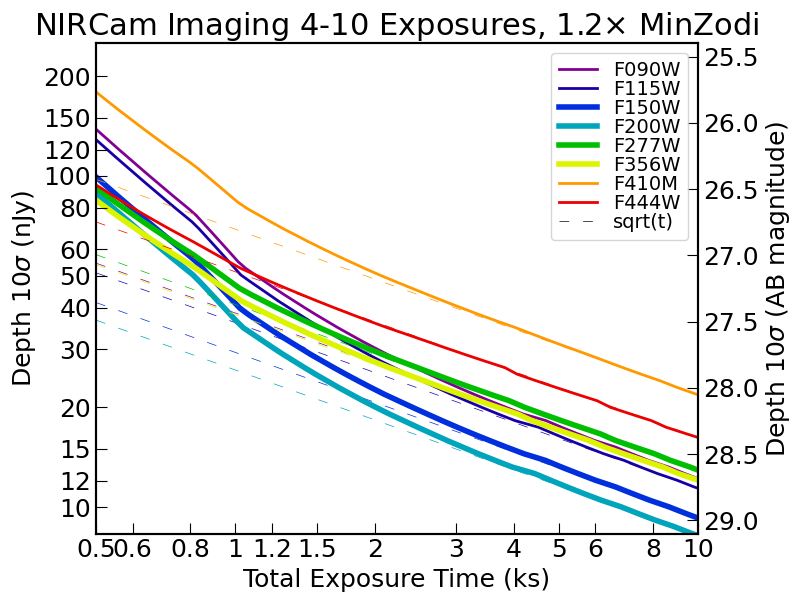

In [67]:
#fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8.12,6.12))
xlo, xhi = 0.5, 10
verbose = False

for ifilt, filt in enumerate(filts):
    nexp = 4
    lam = int(filt[1:4]) / 100.
    color = scalarMap.to_rgba(lam)

    pmags = []
    t0s = []
    for mag in mags:
        nexp = int(nexp)  # gets loaded in below; picks up where we left off
        infile = 'etc_snr_%dexp_%s_mag%5.2f.txt' % (nexp, filt, mag)
        infile = os.path.join(results_dir, infile)
        if os.path.exists(infile):
            if verbose: print(infile, 'LOADING')
            fin = open(infile, 'r')
            txt = fin.readlines()
            fin.close()
            exptimes = []
            snrs = []
            for line in txt:
                readmode, ngroups, nint, nexp, exptime, snr = line.split()
                exptimes.append(float(exptime))
                snrs.append(float(snr))

            if verbose: print(len(snrs), snrs[-1])
            if len(snrs) > 1:
                if snrs[-1] > snr0:
                    t0 = interp_log(snr0, snrs, exptimes)
                    if verbose: print(mag, t0)
                    pmags.append(mag)
                    t0s.append(t0)
        else:
            if verbose: print(infile, 'DOES NOT EXIST')
            
    t0mins = np.array(t0s) / 1e3
    if 1.3 < lam < 3.8:
        lw = 4
    else:
        lw = 2
    
    if 'w2' in filt:
        lw += 3
    
    if 0: # odd(ifilt):
        ls = '--'
    else:
        ls = '-'
    
    plt.plot(t0mins, pmags, color=color, lw=lw, ls=ls, label=filt.upper())
    
    #dashes = 7, 10
    dashes = 14, 20
    if len(t0mins):
        # sqrt(t) extrapolation from final point on x-axis
        t0 = xhi
        mag = interp_log(t0, t0mins, pmags)
        xrange = np.array([xlo, xhi])
        pmagsqrtt = mag + 1.25 * np.log10(xrange / t0)
        plt.plot(xrange, pmagsqrtt, color=color, lw=0.5, dashes=dashes)
        #pmagsqrtt = mag + 1.25 * np.log10(t0mins / t0)
        #plt.plot(t0mins, pmagsqrtt, color=color, lw=0.5, dashes=dashes)
        
plt.plot((1,1), (1,1), lw=0.5, color='k', dashes=dashes, label='sqrt(t)')
leg = plt.legend(loc=1, labelspacing=0)
plt.semilogx()

d = 1,1.2,1.5,2,3,4,5,6,8
ax.xaxis.set_major_formatter(fmtexp)
ax.xaxis.set_major_locator(ticker.LogLocator(10, d))

plt.xlim(xlo, xhi)
ylo, yhi = 25.4, 29.1
plt.ylim(yhi, ylo)
plt.ylabel('Depth %d$\sigma$ (AB magnitude)' % snr0)
#xlabel('Total Exposure Time (Minutes)')
plt.xlabel('Total Exposure Time (ks)')
plt.title('NIRCam Imaging 4-10 Exposures, 1.2$\\times$ MinZodi')
#plt.title('NIRCam Imaging 4 Exposures, 1.2$\\times$ MinZodi')

ytxm = plt.yticks()[0]
ytxf = map(ABtonJy, ytxm)
dy = 10
#ytxf = np.multiples(np.min(ytxf), np.max(ytxf)+dy, dy)

ax1 = ax.twinx()
ax1.yaxis.set_label_position('left')
ax.yaxis.set_label_position('right')
ax1.yaxis.tick_left()
ax.yaxis.tick_right()

plt.semilogy()

plt.ylabel('Depth %d$\sigma$ (nJy)' % snr0)
yts = map(mapfmtd, ytxf)
ylof = ABtonJy(yhi)
yhif = ABtonJy(ylo)
plt.ylim(ylof, yhif)
#retickylogmult((1,1.2,1.5,2,3,4,5,6,8))
d = 1,1.2,1.5,2,3,4,5,6,8
ax1.yaxis.set_major_formatter(fmtexp)
ax1.yaxis.set_major_locator(ticker.LogLocator(10, d))

plt.ylim(ylof, yhif)
ax1.minorticks_off()
plt.xlim(xlo, xhi)
plt.savefig('NIRCam_depth_10sigma_4-10exp_sqrtt_ETCv2.png')

## About this Notebook
**Authors:**   
Dan Coe & Alicia Canipe

**Updated On:**   
November 14, 2022